In [57]:
!pip install deepxde

In [58]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

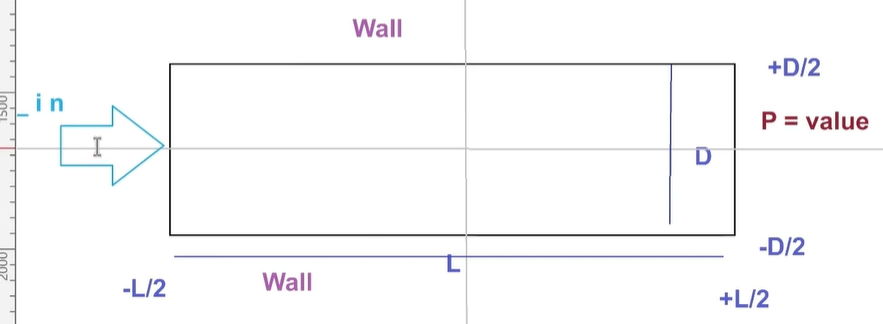

In [59]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

In [60]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

In [61]:
def boundary_wall(X, on_boundary):
    print("X",X)
    print("on_boundary",on_boundary)
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08),np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08)),on_boundary)
    return on_wall

def boundary_inlet(X,on_boundary):
    on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_inlet

def boundary_outlet(X,on_boundary):
    on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
    return on_outlet

In [62]:
bc_wall_u = dde.DirichletBC(geom, lambda X:0., boundary_wall, component= 0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., boundary_wall, component= 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component= 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0.   , boundary_inlet, component= 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X:0.  , boundary_outlet, component= 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X:0.  , boundary_outlet, component= 1)

In [63]:
def pde(X,Y):
    du_x =dde.grad.jacobian(Y, X, i=0, j=0)
    du_y =dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x =dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y =dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x =dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y =dde.grad.jacobian(Y, X, i=2, j=1)

    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    pde_u    = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho) * (du_xx+ du_yy)
    pde_v    = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho) * (dv_xx+ dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u,pde_v,pde_cont]

In [64]:
data = dde.data.PDE(geom,
                   pde,
                   [bc_wall_u,bc_wall_v,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                   num_domain  = 2000,
                   num_boundary= 200,
                   num_test = 200)

Streaming output truncated to the last 5000 lines.
X [0.2919922  0.35007495]
on_boundary False
X [-0.20800781  0.35057473]
on_boundary False
X [0.7919922  0.35107446]
on_boundary False
X [-0.8330078   0.35157424]
on_boundary False
X [0.16699219 0.35207397]
on_boundary False
X [-0.3330078  0.3525737]
on_boundary False
X [0.6669922  0.35307348]
on_boundary False
X [-0.5830078  0.3535732]
on_boundary False
X [0.4169922 0.354073 ]
on_boundary False
X [-0.08300781  0.3545727 ]
on_boundary False
X [0.9169922  0.35507244]
on_boundary False
X [-0.8955078   0.35557222]
on_boundary False
X [0.10449219 0.35607195]
on_boundary False
X [-0.3955078   0.35657173]
on_boundary False
X [0.6044922  0.35707146]
on_boundary False
X [-0.6455078   0.35757118]
on_boundary False
X [0.3544922  0.35807097]
on_boundary False
X [-0.14550781  0.3585707 ]
on_boundary False
X [0.8544922  0.35907048]
on_boundary False
X [-0.7705078  0.3595702]
on_boundary False
X [0.22949219 0.36007   ]
on_boundary False
X [-0.2705078

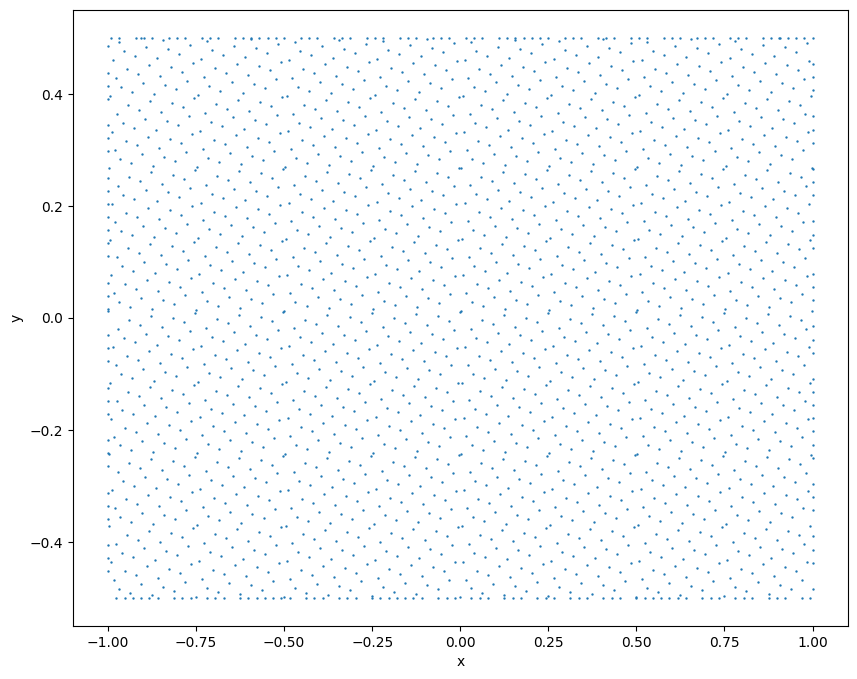

In [65]:
plt.figure(figsize=(10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [66]:
net = dde.maps.FNN([2] + [64]*5 + [3], "tanh", "Glorot uniform")

In [67]:
from functools import lru_cache
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.076013 s

'compile' took 1.703420 s



In [68]:
LossHistory, train_state = model.train(epochs=100000)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [8.00e-03, 1.02e-01, 5.30e-02, 1.57e-02, 2.05e-02, 1.21e+00, 4.20e-02, 7.18e-03, 4.29e-02]    [6.81e-03, 1.02e-01, 5.46e-02, 1.57e-02, 2.05e-02, 1.21e+00, 4.20e-02, 7.18e-03, 4.29e-02]    []  
1000      [1.48e-03, 1.81e-03, 8.20e-03, 2.73e-02, 1.70e-02, 3.59e-02, 1.43e-03, 2.81e-04, 1.28e-04]    [1.10e-03, 1.57e-03, 5.23e-03, 2.73e-02, 1.70e-02, 3.59e-02, 1.43e-03, 2.81e-04, 1.28e-04]    []  
2000      [1.34e-03, 9.61e-04, 4.60e-03, 2.13e-02, 1.33e-02, 2.85e-02, 8.17e-04, 1.45e-04, 5.31e-05]    [9.56e-04, 5.43e-04, 2.64e-03, 2.13e-02, 1.33e-02, 2.85e-02, 8.17e-04, 1.45e-04, 5.31e-05]    []  
3000      [4.64e-03, 1.57e-03, 3.33e-03, 1.83e-02, 1.12e-02, 2.26e-02, 2.29e-03, 3.82e-05, 2.45e-05]    [2.63e-03, 1.15e-03, 1.53e-03, 1.83e-02, 1.12e-02, 2.26e-0

In [69]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile("L-BFGS")
LossHistory, train_state = model.train()
dde.saveplot(LossHistory, train_state, issave=False, isplot=False)

Compiling model...
'compile' took 1.007406 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
100000    [1.80e-03, 6.14e-04, 4.78e-04, 7.03e-03, 1.50e-03, 5.84e-03, 1.30e-03, 1.74e-05, 1.50e-06]    [9.96e-04, 3.98e-04, 1.41e-04, 7.03e-03, 1.50e-03, 5.84e-03, 1.30e-03, 1.74e-05, 1.50e-06]    []  
100033    [1.80e-03, 6.14e-04, 4.78e-04, 7.03e-03, 1.50e-03, 5.84e-03, 1.30e-03, 1.74e-05, 1.50e-06]    [9.96e-04, 3.98e-04, 1.41e-04, 7.03e-03, 1.50e-03, 5.84e-03, 1.30e-03, 1.74e-05, 1.50e-06]    []  

Best model at step 97000:
  train loss: 1.82e-02
  test loss: 1.71e-02
  test metric: []

'train' took 6.028959 s



In [70]:
samples = geom.random_points(500000)
result = model.predict(samples)

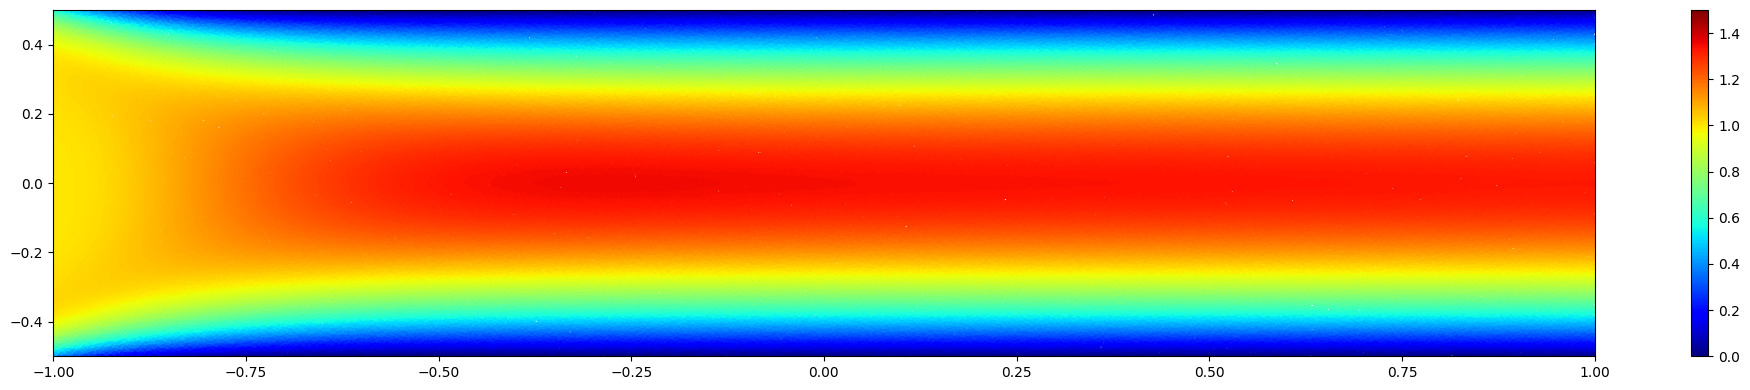

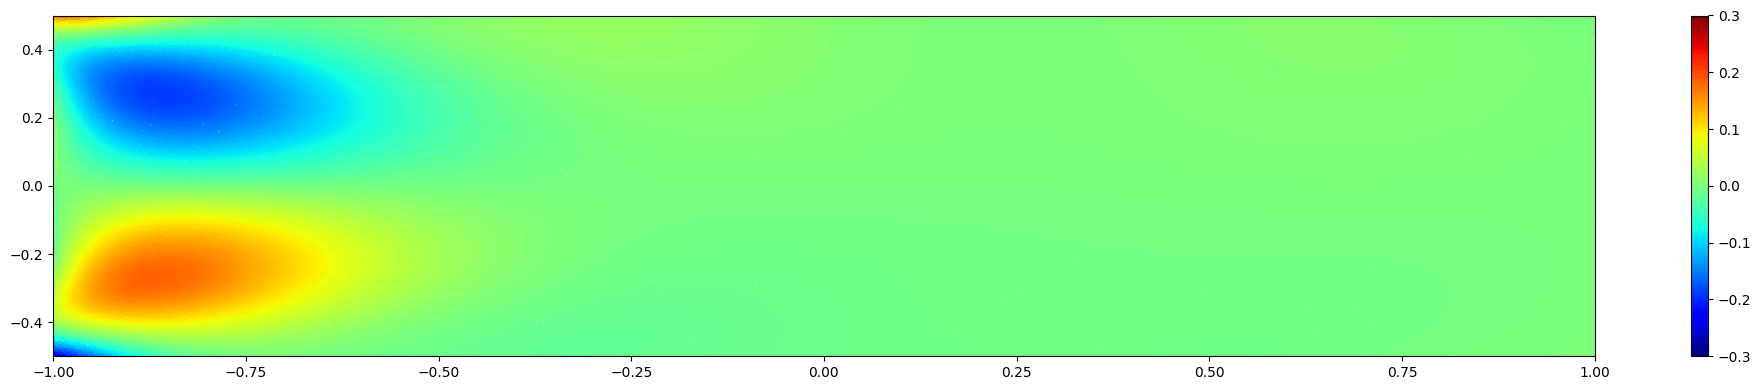

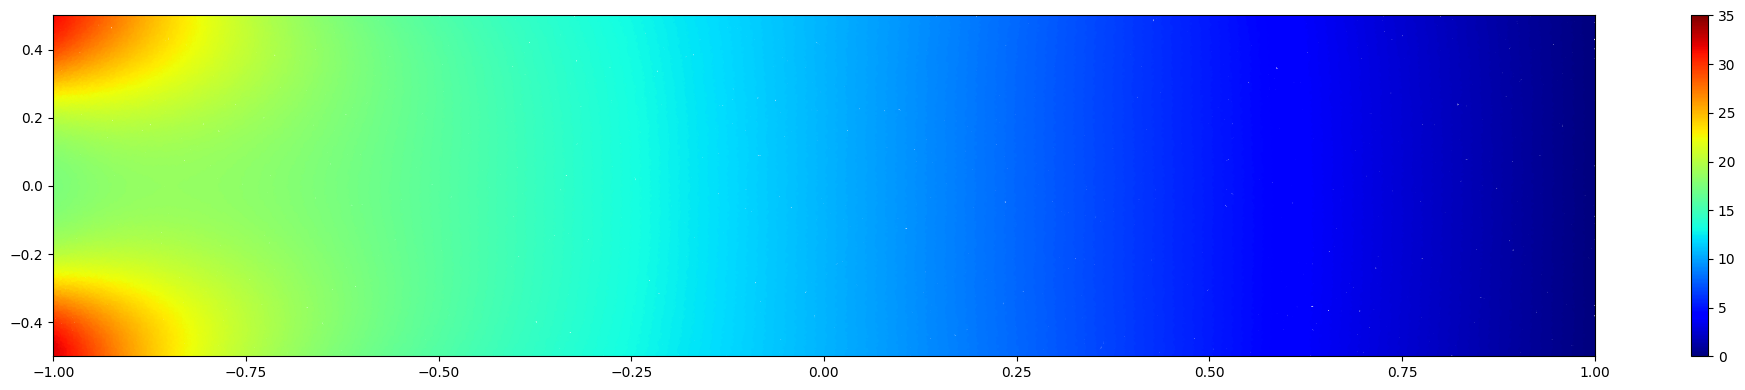

In [71]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'jet',
               s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()